# Hybrid Recommendation using LightFM

# Importing the required libraries

In [1]:
import pandas as pd # pandas for data manipulation
import numpy as np # numpy for sure
from scipy.sparse import coo_matrix # for constructing sparse matrix
# lightfm
from lightfm import LightFM # model
from lightfm.evaluation import auc_score

# timing
import time

# Importing the data from excel

In [2]:
# import the data
order=pd.read_excel('../data/Rec_sys_data.xlsx','order')
customer=pd.read_excel('../data/Rec_sys_data.xlsx','customer')
product=pd.read_excel('../data/Rec_sys_data.xlsx','product')

# Merging the datasets

In [3]:
# merge the data
full_table=pd.merge(order,customer,left_on=['CustomerID'], right_on=['CustomerID'], how='left')
full_table=pd.merge(full_table,product,left_on=['StockCode'], right_on=['StockCode'], how='left')

In [4]:
"Order Shape", order.shape, "Customer Shape", customer.shape, "Product Shape", product.shape, "Full Table Shape", full_table.shape

('Order Shape',
 (272404, 9),
 'Customer Shape',
 (4372, 6),
 'Product Shape',
 (29912, 6),
 'Full Table Shape',
 (272404, 19))

In [5]:
# check for first 5 rows for order data
order.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850


In [6]:
# check for first 5 rows for customer data
customer.head()

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment
0,13089,male,53,High,8625,Small Business
1,15810,female,22,Low,87797,Small Business
2,15556,female,29,High,29257,Corporate
3,13137,male,29,Medium,97818,Middle class
4,16241,male,36,Low,79200,Small Business


In [8]:
customer["Customer Segment"].unique(), customer["Income"].unique(), customer["Gender"].unique()

(array(['Small Business', 'Corporate', 'Middle class'], dtype=object),
 array(['High', 'Low', 'Medium'], dtype=object),
 array(['male', 'female'], dtype=object))

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

## Setting some matplotlib params

In [10]:
from cycler import cycler

# Setting the color cycle for plotting
plt.rcParams['axes.prop_cycle'] = cycler(color=['#10A37F', '#147960', '#024736'])

# Setting the backend for inline display, suitable for Jupyter notebooks or similar environments
plt.rcParams['backend'] = 'module://matplotlib_inline.backend_inline'

# Enabling grid by default on axes
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'both'
plt.rcParams['axes.grid.which'] = 'major'

# Setting axes appearance
plt.rcParams['axes.edgecolor'] = (0.1, 0.1, 0.1)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = (0.1, 0.1, 0.1)
plt.rcParams['axes.labelsize'] = 12.0
plt.rcParams['axes.titlecolor'] = 'auto'
plt.rcParams['axes.titlesize'] = 16.0

# Configuring the appearance of ticks
plt.rcParams['xtick.color'] = (0.1, 0.1, 0.1)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 12.0
plt.rcParams['ytick.color'] = (0.1, 0.1, 0.1)
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 12.0

## Plotting distributions for some features on each dataset

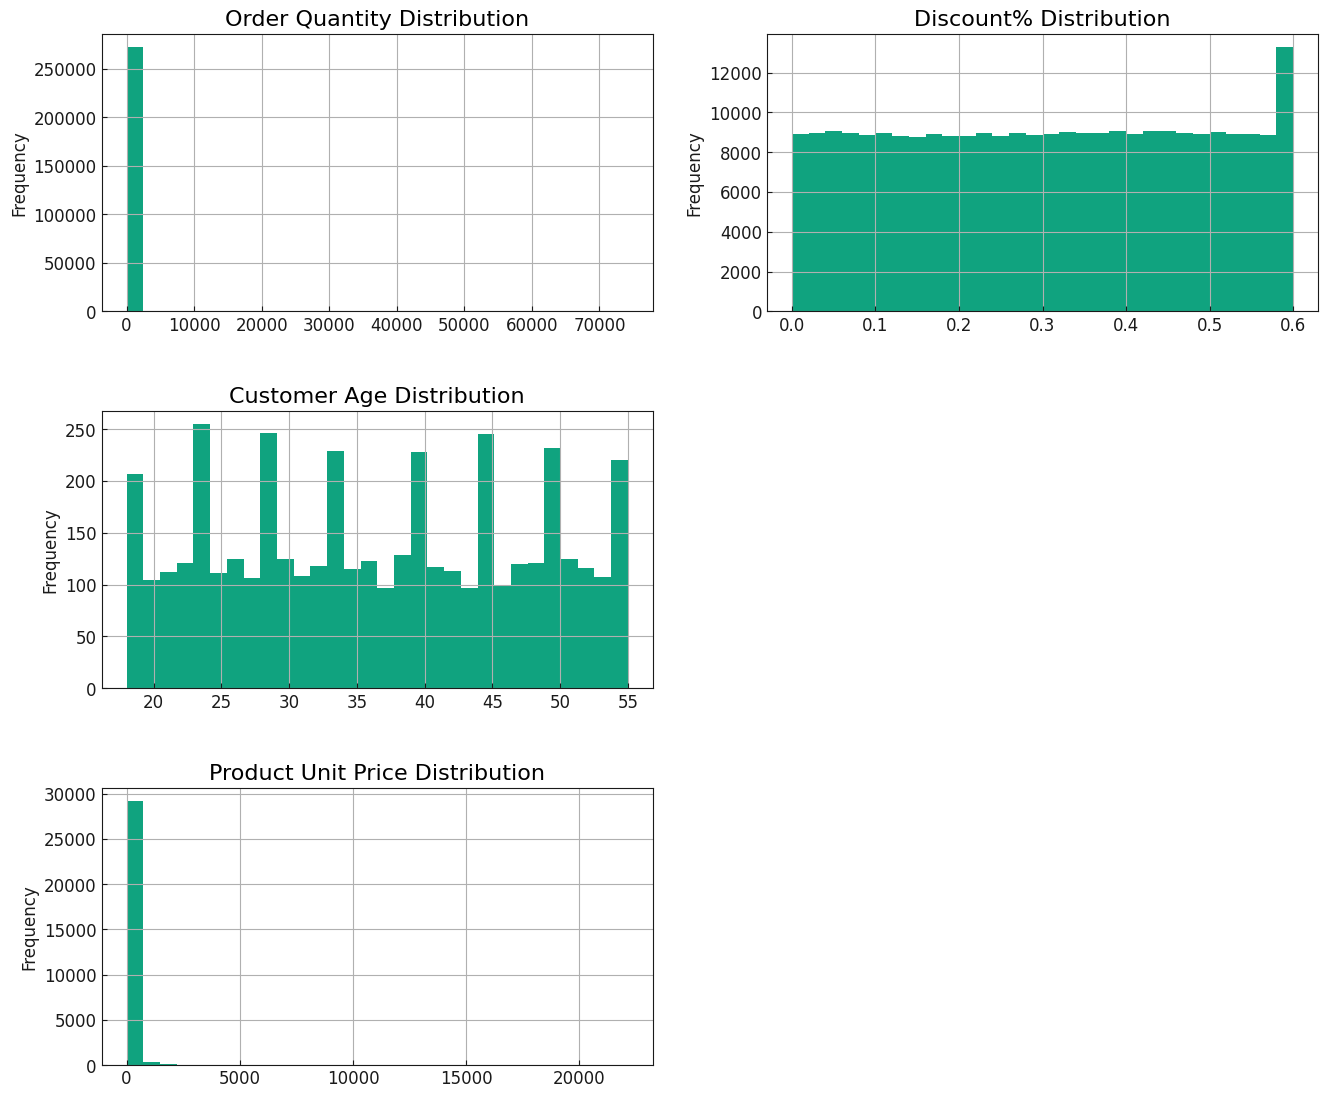

In [11]:
# Setting up the matplotlib figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
fig.tight_layout(pad=5.0)

# Plotting histograms for Order Data
order['Quantity'].plot(kind='hist', bins=30, ax=axes[0, 0], title='Order Quantity Distribution')
order['Discount%'].plot(kind='hist', bins=30, ax=axes[0, 1], title='Discount% Distribution')

# Plotting histograms for Customer Data
customer['Age'].plot(kind='hist', bins=30, ax=axes[1, 0], title='Customer Age Distribution')

# Plotting histograms for Product Data
product['Unit Price'].plot(kind='hist', bins=30, ax=axes[2, 0], title='Product Unit Price Distribution')

# Hiding empty subplots
axes[1, 1].axis('off')
axes[2, 1].axis('off')

plt.show()


### Observations from the plots above
* **Order Quantity Distribution**: The majority of orders contain a relatively small quantity of items, as evidenced by the sharp peak at the lower end of the scale. There are very few large quantity orders, which indicates that bulk purchases are rare.

* **Discount% Distribution**: The distribution of discounts is fairly uniform across the range, with a slight increase in frequency as the discount percentage increases. This could suggest that larger discounts are more commonly offered or that orders with larger discounts are more frequent.

* **Customer Age Distribution**: The age of customers appears to be fairly evenly distributed, with slight increases around the ages of 30 and 50. There are no particularly dominant age groups, which suggests a diverse customer base in terms of age.

* **Product Unit Price Distribution**: There is a large spike in the number of products with a very low unit price, indicating that most products are priced on the lower end. The frequency drops significantly for higher-priced items, showing that expensive products are much less common.

In [12]:
# check for first 5 rows for product data
product.head()

,StockCode,Product Name,Description,Category,Brand,Unit Price
0,22629,Ganma Superheroes Ordinary Life Case For Samsu...,"New unique design, great gift.High quality pla...",Cell Phones|Cellphone Accessories|Cases & Prot...,Ganma,13.99
1,21238,Eye Buy Express Prescription Glasses Mens Wome...,Rounded rectangular cat-eye reading glasses. T...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,19.22
2,22181,MightySkins Skin Decal Wrap Compatible with Ni...,Each Nintendo 2DS kit is printed with super-hi...,Video Games|Video Game Accessories|Accessories...,Mightyskins,14.99
3,84879,Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...,The sheerest compression stocking in its class...,Health|Medicine Cabinet|Braces & Supports,Medi,62.38
4,84836,Stupell Industries Chevron Initial Wall D cor,Features: -Made in the USA. -Sawtooth hanger o...,Home Improvement|Paint|Wall Decals|All Wall De...,Stupell Industries,35.99


In [13]:
# Creating the list of unique users
def unique_users(data, column):
    return np.sort(data[column].unique())

# Creating the list of unique produts
def unique_items(data, column):
    item_list = data[column].unique()
    return item_list

def features_to_add(customer, column1,column2,column3):
    customer1 = customer[column1]
    customer2 = customer[column2]
    customer3 = customer[column3]
    return pd.concat([customer1,customer3,customer2], ignore_index = True).unique()

# Create id mappings to convert user_id, item_id, and feature_id
def mapping(users, items, features):
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    for user_index, user_id in enumerate(users):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id

    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(items):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id

    feature_to_index_mapping = {}
    index_to_feature_mapping = {}
    for feature_index, feature_id in enumerate(features):
        feature_to_index_mapping[feature_id] = feature_index
        index_to_feature_mapping[feature_index] = feature_id


    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping



In [15]:
# create the user, item, feature lists
users = unique_users(order, "CustomerID")
items = unique_items(product, "Product Name")
features = features_to_add(customer,'Customer Segment',"Age","Gender")

In [16]:
pd.DataFrame(users).head()

,0
0,12346
1,12347
2,12348
3,12350
4,12352


In [17]:
pd.DataFrame(items).head()

,0
0,Ganma Superheroes Ordinary Life Case For Samsu...
1,Eye Buy Express Prescription Glasses Mens Wome...
2,MightySkins Skin Decal Wrap Compatible with Ni...
3,Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...
4,Stupell Industries Chevron Initial Wall D cor


In [18]:
pd.DataFrame(features).head(20)

,0
0,Small Business
1,Corporate
2,Middle class
3,male
4,female
5,53
6,22
7,29
8,36
9,48


In [19]:
# generate mapping, LightFM library can't read other than (integer) index
user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping = mapping(users, items, features)

In [20]:
full_table.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID,Gender,Age,Income,Zipcode,Customer Segment,Product Name,Description,Category,Brand,Unit Price
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850,female,48,Medium,84306,Middle class,"3 1/2""W x 20""D x 20""H Funston Craftsman Smooth...",Our Rustic Collection is an instant classic. O...,Home Improvement|Hardware|Brackets and Angle I...,Ekena Milwork,199.11
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850,female,48,Medium,84306,Middle class,Awkward Styles Shamrock Flag St. Patrick's Day...,Our St Patrick's Day Collection is perfect for...,Clothing|Men|Mens T-Shirts & Tank Tops|Mens Gr...,Awkward Styles,23.95
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850,female,48,Medium,84306,Middle class,Ebe Men Black Rectangle Half Rim Spring Hinge ...,Count on EBE for all of your eye correction ne...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,26.99
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850,female,48,Medium,84306,Middle class,MightySkins Skin Decal Wrap Compatible with Ap...,Mightyskins are removable vinyl skins for prot...,Electronics|Electronics Learning Center|Ads Fr...,Mightyskins,14.99
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850,female,48,Medium,84306,Middle class,awesome since 1948 - 69th birthday gift t-shir...,awesome since 1948 - 69th birthday gift t-shir...,Clothing|Men|Mens T-Shirts & Tank Tops|Mens T-...,Shirtinvaders,49.33


In [21]:
user_to_product_rating_train=full_table[['CustomerID','Product Name','Quantity']]

In [22]:
product_to_feature=full_table[['Product Name','Customer Segment','Quantity']]

In [23]:
user_to_product_rating_train=user_to_product_rating_train.groupby(['CustomerID','Product Name']).agg({'Quantity':'sum'}).reset_index()

In [24]:
user_to_product_rating_train.tail()

,CustomerID,Product Name,Quantity
138397,18287,Sport-Tek Ladies PosiCharge Competitor Tee,24
138398,18287,Ultra Sleek And Spacious Pearl White Lacquer 1...,6
138399,18287,"Union 3"" Female Ports Stainless Steel Pipe Fit...",12
138400,18287,awesome since 1948 - 69th birthday gift t-shir...,4
138401,18287,billyboards Porcelain Menu Chalkboard,6


# train test split

In [25]:
from sklearn.model_selection import train_test_split

In [27]:
# perform train test split - 67:33 percent
user_to_product_rating_train,user_to_product_rating_test = train_test_split(user_to_product_rating_train,
                                                                            test_size=0.33, random_state=42)

In [28]:
# check the shape of train data
user_to_product_rating_train.shape

(62128, 3)

In [29]:
# check the shape of test data
user_to_product_rating_test.shape

(30601, 3)

In [31]:
product_to_feature = product_to_feature.groupby(['Product Name', 'Customer Segment']).agg({'Quantity': 'sum'}).reset_index()

In [31]:
# perform groupby
#product_to_feature=product_to_feature.groupby(['Product Name','Customer Segment']).agg({'Quantity':'sum'}).reset_index()

In [32]:
product_to_feature.head()

,Product Name,Customer Segment,Quantity
0,"""In Vinyl W.e Trust"" Rasta Quote Men's T-shirt",Corporate,712
1,"""In Vinyl W.e Trust"" Rasta Quote Men's T-shirt",Middle class,272
2,"""In Vinyl W.e Trust"" Rasta Quote Men's T-shirt",Small Business,388
3,"""Soccer"" Vinyl Graphic - Large - Ivory",Corporate,1940
4,"""Soccer"" Vinyl Graphic - Large - Ivory",Middle class,1418


In [33]:
# create a function for interactions
def interactions(data, row, col, value, row_map, col_map):

    row = data[row].apply(lambda x: row_map[x]).values
    col = data[col].apply(lambda x: col_map[x]).values
    value = data[value].values

    return coo_matrix((value, (row, col)), shape = (len(row_map), len(col_map)))


In [34]:
# generate user_item_interaction_matrix for train data
user_to_product_interaction_train = interactions(user_to_product_rating_train, "CustomerID",
                                                    "Product Name", "Quantity", user_to_index_mapping, item_to_index_mapping)

# generate item_to_feature interaction
product_to_feature_interaction = interactions(product_to_feature, "Product Name", "Customer Segment","Quantity",
                                                        item_to_index_mapping, feature_to_index_mapping)

In [35]:
# generate user_item_interaction_matrix for test data
user_to_product_interaction_test = interactions(user_to_product_rating_test, "CustomerID",
                                                    "Product Name", "Quantity", user_to_index_mapping, item_to_index_mapping)

In [36]:
user_to_product_interaction_train

<3647x797 sparse matrix of type '<class 'numpy.int64'>'
	with 62128 stored elements in COOrdinate format>

In [37]:
user_to_product_interaction_test

<3647x797 sparse matrix of type '<class 'numpy.int64'>'
	with 30601 stored elements in COOrdinate format>

# Model building on training set
Parameters:
Loss=warp
epochs=1
num_threads=4

In [39]:
# initialising model with warp loss function
model_with_features = LightFM(loss = "warp")

# fitting the model with hybrid collaborative filtering + content based (product + features)
start = time.time()
#===================


model_with_features.fit_partial(user_to_product_interaction_train,
          user_features=None,
          item_features=product_to_feature_interaction,
          sample_weight=None,
          epochs=100,
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 11.88 seconds


In [40]:
start = time.time()
#===================
auc_with_features = auc_score(model = model_with_features,
                        test_interactions = user_to_product_interaction_test,
                        train_interactions = user_to_product_interaction_train,
                        item_features = product_to_feature_interaction,
                        num_threads = 4, check_intersections=False)
#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

print("average AUC without adding item-feature interaction = {0:.{1}f}".format(auc_with_features.mean(), 2))



time taken = 0.03 seconds
average AUC without adding item-feature interaction = 0.15


# Model building on training set
Parameters:
Loss=logistic
epochs=1
num_threads=4

In [41]:
# initialising model with logistic loss function
model_with_features = LightFM(loss = "logistic")

# fitting the model with hybrid collaborative filtering + content based (product + features)
start = time.time()
#===================


model_with_features.fit_partial(user_to_product_interaction_train,
          user_features=None,
          item_features=product_to_feature_interaction,
          sample_weight=None,
          epochs=100,
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 8.74 seconds


In [42]:
start = time.time()
#===================
auc_with_features = auc_score(model = model_with_features,
                        test_interactions = user_to_product_interaction_test,
                        train_interactions = user_to_product_interaction_train,
                        item_features = product_to_feature_interaction,
                        num_threads = 4, check_intersections=False)
#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

print("average AUC without adding item-feature interaction = {0:.{1}f}".format(auc_with_features.mean(), 2))


time taken = 0.03 seconds
average AUC without adding item-feature interaction = 0.89


# Model building on training set
Parameters:
Loss=bpr
epochs=1
num_threads=4

In [44]:
# initialising model with bpr loss function
model_with_features = LightFM(loss = "bpr")

# fitting the model with hybrid collaborative filtering + content based (product + features)
start = time.time()
#===================


model_with_features.fit_partial(user_to_product_interaction_train,
          user_features=None,
          item_features=product_to_feature_interaction,
          sample_weight=None,
          epochs=100,
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 14.82 seconds


In [45]:
start = time.time()
#===================
auc_with_features = auc_score(model = model_with_features,
                        test_interactions = user_to_product_interaction_test,
                        train_interactions = user_to_product_interaction_train,
                        item_features = product_to_feature_interaction,
                        num_threads = 4, check_intersections=False)
#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

print("average AUC without adding item-feature interaction = {0:.{1}f}".format(auc_with_features.mean(), 2))


time taken = 0.03 seconds
average AUC without adding item-feature interaction = 0.29


# Model building on training set
Parameters:
Loss=logistic
epochs=100
num_threads=20

In [46]:
model_with_features = LightFM(loss = "logistic")

# fitting the model with hybrid collaborative filtering + content based (product + features)
start = time.time()
#===================


model_with_features.fit_partial(user_to_product_interaction_train,
          user_features=None,
          item_features=product_to_feature_interaction,
          sample_weight=None,
          epochs=100,
          num_threads=20,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 8.11 seconds


In [47]:
start = time.time()
#===================
auc_with_features = auc_score(model = model_with_features,
                        test_interactions = user_to_product_interaction_test,
                        train_interactions = user_to_product_interaction_train,
                        item_features = product_to_feature_interaction,
                        num_threads = 4, check_intersections=False)
#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

print("average AUC without adding item-feature interaction = {0:.{1}f}".format(auc_with_features.mean(), 2))


time taken = 0.02 seconds
average AUC without adding item-feature interaction = 0.88


In [48]:
def train_test_merge(training_data, testing_data):

    # initialising train dict
    train_dict = {}
    for row, col, data in zip(training_data.row, training_data.col, training_data.data):
        train_dict[(row, col)] = data

    # replacing with the test set

    for row, col, data in zip(testing_data.row, testing_data.col, testing_data.data):
        train_dict[(row, col)] = max(data, train_dict.get((row, col), 0))


    # converting to the row
    row_list = []
    col_list = []
    data_list = []
    for row, col in train_dict:
        row_list.append(row)
        col_list.append(col)
        data_list.append(train_dict[(row, col)])

    # converting to np array

    row_list = np.array(row_list)
    col_list = np.array(col_list)
    data_list = np.array(data_list)

    return coo_matrix((data_list, (row_list, col_list)), shape = (training_data.shape[0], training_data.shape[1]))

In [49]:
user_to_product_interaction = train_test_merge(user_to_product_interaction_train,
                                                 user_to_product_interaction_test)

In [50]:
user_to_product_interaction

<3647x797 sparse matrix of type '<class 'numpy.float64'>'
	with 92729 stored elements in COOrdinate format>

# Final Model after combining the train and test data
Parameters:
Loss=warp
epochs=500
num_threads=20

In [51]:
# retraining the final model with combined dataset

final_model = LightFM(loss = "logistic",no_components=30)

# fitting to combined dataset

start = time.time()
#===================

final_model.fit(user_to_product_interaction,
          user_features=None,
          item_features=product_to_feature_interaction,
          sample_weight=None,
          epochs=500,
          num_threads=10,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 146.28 seconds


In [55]:
def get_recommendations(model,user,items,user_to_product_interaction_matrix,user2index_map,product_to_feature_interaction_matrix):

    # getting the userindex

        userindex = user2index_map.get(user, None)

        if userindex == None:
            return None

        users = userindex

        # products already bought

        known_positives = items[user_to_product_interaction_matrix.tocsr()[userindex].indices]
        print('User index =',users)

        # scores from model prediction
        scores = model.predict(user_ids = users, item_ids = np.arange(user_to_product_interaction_matrix.shape[1]),item_features=product_to_feature_interaction_matrix)

        # top items

        top_items = items[np.argsort(-scores)]

        # printing out the result
        print("User %s" % user)
        print("     Known positives:")  # already known products

        for x in known_positives[:10]:
            print("                  %s" % x)


        print("     Recommended:")  # products that are reccommended to the user

        for x in top_items[:10]:
            print("                  %s" % x)


In [56]:
# check for the reccomendation
get_recommendations(final_model,17017,items,user_to_product_interaction,user_to_index_mapping,product_to_feature_interaction)

User index = 2888
User 17017
     Known positives:
                  Ganma Superheroes Ordinary Life Case For Samsung Galaxy Note 5 Hard Case Cover
                  MightySkins Skin Decal Wrap Compatible with Nintendo Sticker Protective Cover 100's of Color Options
                  MightySkins Skin Decal Wrap Compatible with Lenovo Sticker Protective Cover 100's of Color Options
                  Union 3" Female Ports Stainless Steel Pipe Fitting
                  Ebe Women Reading Glasses Reader Cheaters Anti Reflective Lenses TR90 ry2209
                  3 1/2"W x 32"D x 36"H Traditional Arts & Crafts Smooth Bracket, Douglas Fir
                  MightySkins Skin Decal Wrap Compatible with HP Sticker Protective Cover 100's of Color Options
                  MightySkins Skin Decal Wrap Compatible with Apple Sticker Protective Cover 100's of Color Options
                  New Way 1120 - Crewneck Your Job Could Be Worse Toilet Paper Sweatshirt 4XL Light Pink
                  3 1/2"

In [57]:
get_recommendations(final_model,18287,items,user_to_product_interaction,user_to_index_mapping,product_to_feature_interaction)

User index = 3646
User 18287
     Known positives:
                  MightySkins Skin Decal Wrap Compatible with Nintendo Sticker Protective Cover 100's of Color Options
                  Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lace Silicone Top Band CT Wheat II - Ankle 8-8.75 inches
                  MightySkins Skin Decal Wrap Compatible with DJI Sticker Protective Cover 100's of Color Options
                  Union 3" Female Ports Stainless Steel Pipe Fitting
                  Ebe Women Reading Glasses Reader Cheaters Anti Reflective Lenses TR90 ry2209
                  6pc Boy Formal Necktie Black & White Suit Set Satin Bow tie Baby Sm-20 Teen
                  Buckle-Down PC-W30348-NM Cameroon Flags Plastic Clip Collar
                  Business Essentials 8" x 8" x 5" Corrugated Mailers, 12-Pack
                  6 1/4 x 6 1/4 Gatefold Invitation - Mandarin Orange (500 Qty.)
                  Ultra Sleek And Spacious Pearl White Lacquer 18 Note Music Jewelry Box - We've Only 

In [58]:
get_recommendations(final_model,13933,items,user_to_product_interaction,user_to_index_mapping,product_to_feature_interaction)

User index = 1000
User 13933
     Known positives:
                  MightySkins Skin Decal Wrap Compatible with DJI Sticker Protective Cover 100's of Color Options
                  Ebe Women Reading Glasses Reader Cheaters Anti Reflective Lenses TR90 ry2209
                  MightySkins Skin Decal Wrap Compatible with Smok Sticker Protective Cover 100's of Color Options
                  3 1/2"W x 20"D x 20"H Funston Craftsman Smooth Bracket, Douglas Fir
                  Ebe Reading Glasses Mens Womens Blue Silver Temples Anti Glare remarkable grade ckb8147
                  Port Authority J335 Hooded Core Soft Shell Jacket, Dress Blue Navy/ Battleship Grey, XS
                  6 1/4 x 6 1/4 Gatefold Invitation - Mandarin Orange (500 Qty.)
                  Awkward Styles Sugar Skull Shirts for Men Jolly Roger Skull and Crossbones Men's Tee Shirt Tops Day of Dead Tshirts Pirate Flag Shirts Skull T-shirts Dia de Los Muertos T Shirts for Men
                  Women's Breeze Walker
  